<h1><center>CSC 7343 (Deep Learning Systems) - Final Project</center></h1>
    <h2><center>Noise Vaccination: Assessing Model Performance with Random Perturbations of Input Data</center>
    <center>Frank Saforo & Maxwell Reeser</center></h2>

<h2>Table of Contents</h2>

<hr>
<p>The goal of this project is to explore the varying effects of properly tuned noise on the performance of state-of-the-art CNN architectures </p>
<ul>
    <li><a href="#Task_0">Global Objects, Data Setup, and Functions</a></li>
        <ul>
             <li><a href="#Task_1.1">Global Libraries</a></li>
             <li><a href="#Task_1.2">Auxillary Functions</a></li>
             <li><a href="#Task_1.3">Data Setup</a></li>
            <li><a href="#Task_1.4">Noise Visualizations</a></li>
    </ul>
    <li><a href="#Task_2">ResNet Model Definintion</a></li>
            <ul>
             <li><a href="#Task_21">Model Performance with Gaussian Noise</a></li>
             <li><a href="#Task_22">Model Performance with Poisson Noise</a></li>
             <li><a href="#Task_23">Model Performance with Salt and Pepper Noise</a></li>
            <li><a href="#Task_24">Model Performance with Local Variation Noise</a></li>
    </ul>
    <li><a href="#Task_3">Variational Autoencoders (VAE)</a></li>
            <ul>
             <li><a href="#Task_31">VAE Model Definition</a></li>
             <li><a href="#Task_32">VAE with Noise</a></li>
             <li><a href="#Task_33">VAE without Noise</a></li>
             <li><a href="#Task_34">Summary of Comparisons</a></li>
    </ul>
</ul>

<hr>
<hr>

<h1>Global Functions</h1>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from skimage import img_as_float

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

import os
import argparse
import random
import sys
import time
import math

from random_noise import random_noise

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

<h2>Data Setup</h2>

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

evens = list(range(0, len(trainset), 2))
evens = random.sample(evens, 1000)

trainset_1 = torch.utils.data.Subset(trainset, evens)


trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=100, shuffle=True, num_workers=2) #bs=150

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2) #bs=100

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Samples for preliminary visualizations
trainloader_play = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)


<h2>Data Visualizations</h2>

In [5]:
# functions to show an image
def imshow2(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader_play)
images, labels = dataiter.next()

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  cat  bird  deer   car


<h3>Original Data</h3>

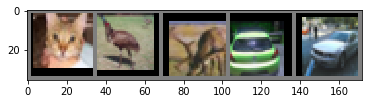

In [6]:
imshow2(torchvision.utils.make_grid(images))

<h3>Noisy Data</h3>

In [7]:
# Add some random noise to sampled images
gaussian_noisy_image = random_noise(images, mode="gaussian")
poisson_noisy_image = random_noise(images, mode="poisson")
salt_noisy_image = random_noise(images, mode="salt")
pepper_noisy_image = random_noise(images, mode="pepper")
sp_noisy_image = random_noise(images, mode="s&p")
speckle_noisy_image = random_noise(images, mode="speckle")
localvar_noisy_image = random_noise(images, mode="localvar")

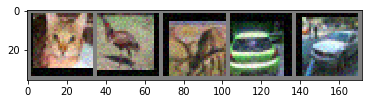

In [8]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(gaussian_noisy_image))))

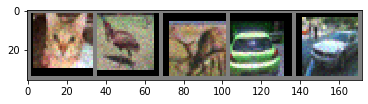

In [9]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(poisson_noisy_image))))

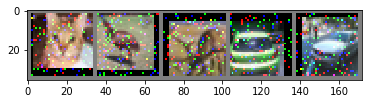

In [10]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(salt_noisy_image))))

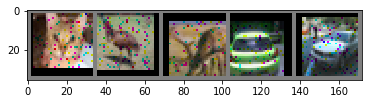

In [11]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(pepper_noisy_image))))

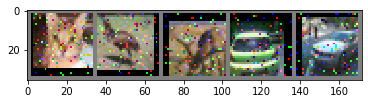

In [12]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(sp_noisy_image))))

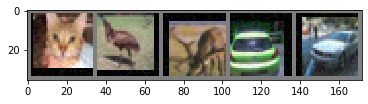

In [13]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(speckle_noisy_image))))

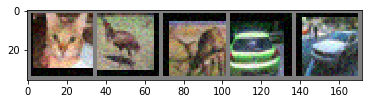

In [14]:
imshow2(torchvision.utils.make_grid(torch.Tensor(list(localvar_noisy_image))))

<h3>Some Auxillary Functions</h3>

In [15]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

                
term_width = 10
term_width = int(term_width)


TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

<hr>
<hr>

<h1>Model Definition - ResNet</h1>

In [16]:
'''ResNet Model
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])


def test():
    net = ResNet50()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

# test()

### End of Model Definition

In [18]:
# Training
def train(model, epoch, mode_str, device, criterion, optimizer):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        #print(inputs.shape)
        inputs = torch.Tensor(list(random_noise(inputs.cpu(), mode=mode_str))).cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

# Testing
def test(model, epoch, mode_str, device, criterion, best_acc):
    #global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            mode_str+'_net': model.state_dict(),
            mode_str+'_acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+mode_str+'_ckpt.pth')
        best_acc = acc
        

def run_cuda_model(mode_str, number):
    device = 'cuda'
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    # Model
    model = ResNet50()
    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    for epoch in range(start_epoch, start_epoch+30):
        train(model, epoch, mode_str, device, criterion, optimizer)
        test(model, epoch, mode_str, device, criterion, best_acc)
    torch.save(model.state_dict(), 'resnet_'+mode_str+'_'+str(number)+'.pt')
    

## Model Performance

In [67]:
number = 0
modes = ['gaussian', 'poisson', 'localvar', 's&p']
for i in range(len(modes)):
    run_cuda_model(modes[i], number)
    print('--------------------------------------')
    print('--------------------------------------')


Epoch: 0
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32]).......................................]  Step: 48s325ms | Tot: 5ms | Loss: 2.467 | Train Acc: 11.000% (11/100) 1/10 
torch.Size([100, 3, 32, 32]).......................................]  Step: 248ms | Tot: 254ms | Loss: 8.203 | Train Acc: 11.500% (23/200) 2/10 
torch.Size([100, 3, 32, 32]).......................................]  Step: 241ms | Tot: 495ms | Loss: 13.445 | Train Acc: 11.000% (33/300) 3/10 
torch.Size([100, 3, 32, 32]).......................................]  Step: 244ms | Tot: 740ms | Loss: 17.335 | Train Acc: 11.000% (44/400) 4/10 
torch.Size([100, 3, 32, 32])>......................................]  Step: 250ms | Tot: 990ms | Loss: 18.949 | Train Acc: 11.400% (57/500) 5/10 
torch.Size([100, 3, 32, 32])======>................................]  Step: 258ms | Tot: 1s249ms | Loss: 18.726 | Train Acc: 11.500% (69/600) 6/10 
torch.Size([100, 3, 32, 32])=============>.........................]  Step: 255ms | 

KeyboardInterrupt: 

<hr>
<hr>

# VAE Data Setup

In [2]:
num_epochs = 20;
batch_size = 200;
learning_rate = 0.001;

## Loading Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

for i, (images, labels) in enumerate(train_loader):
    if i == 0:
        print(images[0].shape, images[0], labels[0])
    else:
        break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) tensor([[[-0.7333, -0.7255, -0.8431,  ..., -0.7725, -0.7333, -0.8118],
         [-0.7333, -0.7176, -0.7490,  ..., -0.7647, -0.7333, -0.7804],
         [-0.7098, -0.6706, -0.6941,  ..., -0.5373, -0.4902, -0.5608],
         ...,
         [ 0.0431, -0.0039, -0.0275,  ..., -0.5529, -0.7569, -0.8039],
         [ 0.0824,  0.0902,  0.0431,  ..., -0.1294, -0.3176, -0.5294],
         [-0.0118,  0.0196,  0.1451,  ..., -0.1216,  0.1373, -0.0824]],

        [[-0.5608, -0.5294, -0.6235,  ..., -0.6000, -0.5608, -0.6392],
         [-0.5294, -0.5059, -0.5294,  ..., -0.6157, -0.5843, -0.6314],
         [-0.4980, -0.4667, -0.5059,  ..., -0.4510, -0.4039, -0.4667],
         ...,
         [-0.1529, -0.2078, -0.2314,  ..., -0.6000, -0.8039, -0.8510],
         [-0.1294, -0.1137, -0.1608,  ..., -0.1843, -0.3804, -0.5843],
         [-0.2157, -0.1843, -0.0588,  ..., -0.1843,  0.0667, -0.1529]],

        [[-0.678

## Auxiliary Functions

In [5]:
def vae_compare_samples(model, test_loader, batch_size):
    # Compare original and reconstructed samples
    model.eval()
    val_losses = 0
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.cuda().float()
            recon_batch, mu, logvar, _ = model(data)
            #print(data.shape)
            if i == 1:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 32, 32)[:n]])

                #save_image(comparison.cpu(),
                #         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                orig = data[:n]
                #print(orig)
                recon = recon_batch.view(batch_size, 3, 32, 32)[:n]
                #print(recon)
                fig = plt.figure(figsize=(8,8));
                columns = 4;
                rows = 4;
                combined = torch.cat([orig.cpu(), recon.cpu()])
                #print(combined.shape)
                for i in range(1, 2*n+1):
                    img_xy = np.random.randint(len(trainset))
                    if i % 2 == 1:
                        img = combined[int(i/2)][:,:,:].transpose(0,2).transpose(0,1)
                    else:
                        #print(int(i/2)+n-1)
                        img = combined[int(i/2)+n-1][:,:,:].transpose(0,2).transpose(0,1)
                    fig.add_subplot(rows, columns, i)
                    if i % 2 == 1:
                        plt.title("Original: "+str(int(i/2)+1))
                    else:
                        plt.title("Reconstructed: "+str(int(i/2)))
                    plt.axis('off')
                    plt.imshow(img, cmap='gray')
                plt.show()

In [6]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) *0.0001
    #print("Shape", BCE.shape, KLD)
    return BCE+KLD

In [7]:
def train_vae(model, optimizer, train_loader, test_loader, batch_size, num_epochs, add_noise=False, noise_size=0.2): 
    val_batches = len(test_loader)
    train_losses = np.zeros(num_epochs).astype(float)
    test_losses = np.zeros(num_epochs).astype(float)
    print("Epoch: ", end="")
    for epoch in range(num_epochs):
        print(epoch, end=" ")
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.cuda().float())
            labels = Variable(labels.cuda())
            if add_noise:
                noise = torch.rand(batch_size, 3, 32, 32).cuda()
                noise = noise*noise_size-noise_size*0.5
                images_noise = images+noise
            
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            if add_noise:
                recon_batch, mu, logvar, _ = model(images_noise)
            else:
                recon_batch, mu, logvar, _ = model(images)
            loss = loss_function(recon_batch, images, mu, logvar)
            loss.backward()
            optimizer.step()            
        #print ('Epoch : %d/%d, Train Loss: %.4f'%(epoch+1, num_epochs, loss.data))
        train_losses[epoch] = loss.data

        model.eval()
        val_losses = 0

        for i, (images, labels) in enumerate(test_loader):
            images_test = Variable(images.cuda().float())
            labels_test = Variable(labels.cuda())
            recon_batch, mu, logvar, _ = model(images_test)

            val_losses += loss_function(recon_batch, images_test, mu, logvar).item()
        # print(f"Test losses: {val_losses/val_batches}")
        print ('Epoch : %d/%d, Test Loss: %.4f'%(epoch+1, num_epochs, 1.0*val_losses/val_batches))
        test_losses[epoch] = 1.0*val_losses/val_batches
    return train_losses, test_losses

In [8]:
def graph_loss(train_losses, test_losses, plot_name):
    x = np.arange(num_epochs)
    plt.plot(x, train_losses, label='Train')
    plt.plot(x, test_losses, label='Test')
    plt.title("Loss vs. Epoch")
    plt.xlabel("Training Epoch")
    plt.ylabel("Loss value")
    plt.legend()
    plt.savefig(plot_name + ".png")
    plt.show()

In [9]:
def graph_norms(model, testset, test_loader):
    # Generate set of all 2-norms of encoding vectors
    size = len(testset)
    #print(size)
    norms = np.zeros(size, dtype=float)
    norms_z = norms.copy()
    #print(norms.shape)
    model.eval()
    counter = 0
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            images_test = Variable(images.cuda().float())
            recon_batch, mu, logvar, z = model(images_test)
            for j in range(batch_size):
                encoding = mu[j]
                #print(encoding)
                encoding_reg = z[j]
                norms[counter] = torch.sum(((encoding-encoding.mean())/encoding.std()).pow(2)).pow(0.5)
                norms_z[counter] = torch.norm(encoding_reg, p=2, dim=0)
                if i == 0 and j == 0:
                    print(mu.shape, batch_size, norms[counter], norms_z[counter])
                counter += 1
    #print(norms[:10])
    # Display the distribution of 2-norms for encoding vectors (mu) and regularized encoding vectors
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    # We can set the number of bins with the `bins` kwarg
    ax_0 = plt.subplot('121')
    ax_0.hist(norms, bins=8)
    ax_0.set_title('Mu encoding distribution')

    ax_1 = plt.subplot('122')
    ax_1.hist(norms_z, bins=50)
    ax_1.set_title('Regularized encoding distribution')
    plt.show()

<hr>
<hr>

## Model Definition - VAE

In [10]:
class VAE(nn.Module):
    def __init__(self, batch_size, noise_size=None):
        super(VAE, self).__init__()
        self.batch_size = batch_size
        self.enc_layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2), #
                                        nn.BatchNorm2d(32),
                                        nn.ReLU())
        #self.layer1 = nn.DataParallel(self.layer1)
        self.enc_layer2 = nn.Sequential(nn.Conv2d(32, 64,kernel_size=3, padding=1, stride=2), #
                                        nn.BatchNorm2d(64),
                                        nn.ReLU())
        #self.layer2 = nn.DataParallel(self.layer2)
        self.enc_layer3 = nn.Sequential(nn.Conv2d(64, 128,kernel_size=3, padding=1, stride=2),#
                                        nn.BatchNorm2d(128),
                                        nn.ReLU()) 
        #self.layer3 = nn.DataParallel(self.layer3)
        self.enc_fc1 = nn.Sequential(nn.Linear(128*4*4, 256))
        self.enc_fc2 = nn.Sequential(nn.Linear(128*4*4, 256))
        
        self.dec_fc = nn.Sequential(nn.Linear(256, 128*4*4),
                                    nn.ReLU())
        self.dec_layer1 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride=2, output_padding=1),
                                        nn.ReLU())
        #self.layer1 = nn.DataParallel(self.layer1)
        self.dec_layer2 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride=2, output_padding=1),
                                        nn.ReLU())
        #self.layer2 = nn.DataParallel(self.layer2)
        self.dec_layer3 = nn.Sequential(nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1, stride=2, output_padding=1),
                                        nn.ReLU())
        if noise_size is not None:
            self.noise = True
            self.noise_size = noise_size
        else:
            self.noise = False
        
    def encode(self, x):
        h1 = self.enc_layer1(x)
        h1 = self.enc_layer2(h1)
        h1 = self.enc_layer3(h1)
        # print(h1.shape)
        h1 = h1.view(-1, 128*4*4)
        return self.enc_fc1(h1), self.enc_fc2(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = self.dec_fc(z)
        h3 = h3.view(-1, 128, 4, 4)
        h3 = self.dec_layer1(h3)
        #print(h3.shape)
        h3 = self.dec_layer2(h3)
        #print(h3.shape)
        h3 = self.dec_layer3(h3)
        #print(h3.shape)
        return torch.sigmoid(h3)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #print(z.max(), z.min(), z)
        yard_stick = max(z.max(), abs(z.min()))
        if self.noise and self.training:
            noise = torch.rand(self.batch_size, 256).cuda()
            noise = (noise*2-1.0)*yard_stick*self.noise_size
            z = z+noise
        return self.decode(z), mu, logvar, z
        

#### End Model Definition

### Control Model: Begin Training

In [11]:
control_model = VAE(batch_size).cuda()
optimizer = torch.optim.Adam(control_model.parameters(), lr=learning_rate)

In [12]:
train_losses, test_losses = train_vae(control_model, optimizer, train_loader, test_loader, batch_size, num_epochs)

Epoch: 0 Epoch : 1/20, Test Loss: 423974.6850
1 Epoch : 2/20, Test Loss: 411301.2481
2 

KeyboardInterrupt: 

In [ ]:
torch.save(control_model.state_dict(), 'control_vae_state_2.pt')

### Results

In [ ]:
plot_num = 2

graph_loss(train_losses, test_losses, "vae_loss"+str(plot_num))
graph_norms(control_model, testset, test_loader)
vae_compare_samples(control_model, test_loader, batch_size)

### Adding Noise to input images: Begin Training

In [ ]:
image_noise_model = VAE(batch_size).cuda()
optimizer = torch.optim.Adam(image_noise_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, test_losses = train_vae(image_noise_model, optimizer, 
                                      train_loader, test_loader, 
                                      batch_size, num_epochs,
                                      add_noise=True, noise_size=0.2)        

In [ ]:
torch.save(image_noise_model.state_dict(), 'image_noise_0_2_vae_state_2.pt')

### Results

In [ ]:
graph_loss(train_losses, test_losses, "image_noise_loss"+str(plot_num))
graph_norms(image_noise_model, testset, test_loader)
vae_compare_samples(image_noise_model, test_loader, batch_size)

### Adding Noise to encodings: Begin Training

In [ ]:
encoding_noise_model = VAE(batch_size, noise_size=0.2).cuda()
optimizer = torch.optim.Adam(encoding_noise_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, test_losses = train_vae(encoding_noise_model, 
                                      optimizer, train_loader, 
                                      test_loader, batch_size, 
                                      num_epochs)   

In [ ]:
torch.save(encoding_noise_model.state_dict(), 'encoding_noise_0_2_vae_state_2.pt')

### Results

In [ ]:
graph_loss(train_losses, test_losses, "encoding_noise_loss"+str(plot_num))
graph_norms(encoding_noise_model, testset, test_loader)
vae_compare_samples(encoding_noise_model, test_loader, batch_size)

## Summary of Comparisons

Control Noise Model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


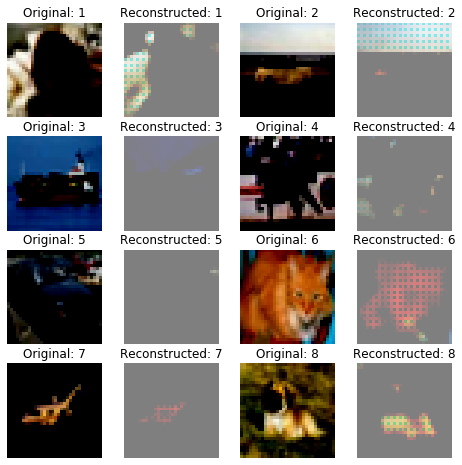

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


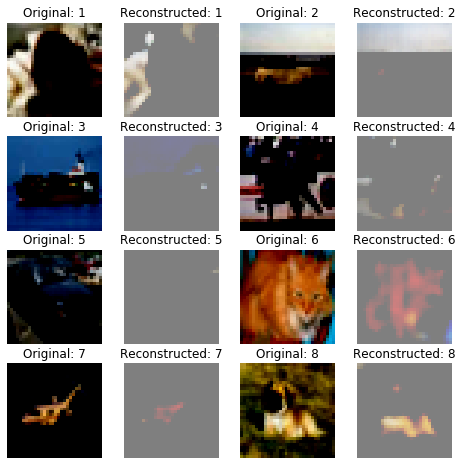

Image Noise Model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


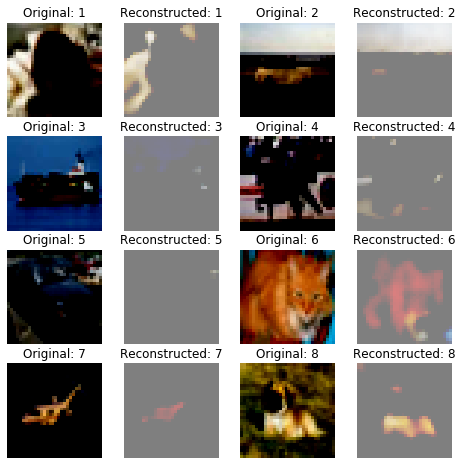

Encoding Noise Model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


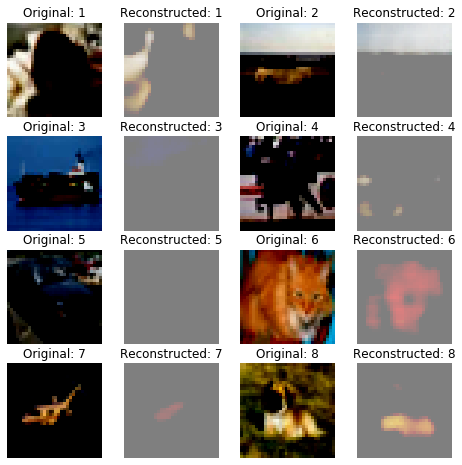

In [13]:
print("Control Noise Model")
control_model = VAE(batch_size).cuda()
control_model.load_state_dict(torch.load('control_vae_state_0.pt'))
vae_compare_samples(control_model, test_loader, batch_size)
control_model.load_state_dict(torch.load('control_vae_state_1.pt'))
vae_compare_samples(control_model, test_loader, batch_size)

print("Image Noise Model")
image_noise_model = VAE(batch_size).cuda()
image_noise_model.load_state_dict(torch.load('image_noise_0_2_vae_state_0.pt'))
vae_compare_samples(image_noise_model, test_loader, batch_size)

print("Encoding Noise Model")
encoding_noise_model = VAE(batch_size, noise_size=0.2).cuda()
encoding_noise_model.load_state_dict(torch.load('encoding_noise_0_2_vae_state_0.pt'))
vae_compare_samples(encoding_noise_model, test_loader, batch_size)